## Data Exploration: 
### Best directors based on ratings per genre

In [1]:
# Dependencies and Setup
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import sqlite3

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Creating db connection
cnx = sqlite3.connect('../Server/movies_db.sqlite')

# Reading data from sqlite database table
movie_df = pd.read_sql_query("SELECT * FROM omdb_movies", cnx)

In [3]:
movie_df.head()

,MovieID,Title,Year,Rated,Released,Runtime,Genre,Director,Budget,GrossRevenue,...,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production
0,0,Look Who's Talking,1989,PG-13,13 Oct 1989,93 min,Comedy,Amy Heckerling,7500000.0,296000000.0,...,https://m.media-amazon.com/images/M/MV5BYWQzNG...,"[{'Source': 'Internet Movie Database', 'Value'...",51.0,5.9,"85,437",tt0097778,movie,12 Feb 2014,"$140,088,813",None
1,1,Driving Miss Daisy,1989,PG,26 Jan 1990,99 min,"Comedy, Drama, Romance",Bruce Beresford,7500000.0,145793296.0,...,https://m.media-amazon.com/images/M/MV5BMDE2ZT...,"[{'Source': 'Internet Movie Database', 'Value'...",81.0,7.3,"114,875",tt0097239,movie,03 Oct 2008,"$106,593,296",None
2,2,Turner & Hooch,1989,PG,28 Jul 1989,97 min,"Comedy, Crime, Drama",Roger Spottiswoode,13000000.0,71079915.0,...,https://m.media-amazon.com/images/M/MV5BMGYxNj...,"[{'Source': 'Internet Movie Database', 'Value'...",36.0,6.2,"74,530",tt0098536,movie,01 Jan 2014,"$71,079,915",None
3,3,Born on the Fourth of July,1989,R,05 Jan 1990,145 min,"Biography, Drama, War",Oliver Stone,14000000.0,161001698.0,...,https://m.media-amazon.com/images/M/MV5BMTgwND...,"[{'Source': 'Internet Movie Database', 'Value'...",75.0,7.2,"113,083",tt0096969,movie,19 Apr 2016,"$70,001,698",None
4,4,Field of Dreams,1989,PG,05 May 1989,107 min,"Drama, Family, Fantasy",Phil Alden Robinson,15000000.0,84431625.0,...,https://m.media-amazon.com/images/M/MV5BNzk5OW...,"[{'Source': 'Internet Movie Database', 'Value'...",57.0,7.5,"124,247",tt0097351,movie,15 Jun 2012,"$64,431,625",None


##  Data Preperation

In [4]:
movie_df.columns

Index(['MovieID', 'Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre',
       'Director', 'Budget', 'GrossRevenue', 'Writer', 'Actors', 'Plot',
       'Language', 'Country', 'Awards', 'Poster', 'Ratings', 'Metascore',
       'imdbRating', 'imdbVotes', 'imdbID', 'Type', 'DVD', 'BoxOffice',
       'Production'],
      dtype='object')

In [5]:
# Keeping only required fields
movie_director_df = movie_df[['MovieID', 'Title','Genre',
       'Director', 'Budget', 'GrossRevenue','Metascore',
       'imdbRating', 'imdbVotes']]
movie_director_df.head()

,MovieID,Title,Genre,Director,Budget,GrossRevenue,Metascore,imdbRating,imdbVotes
0,0,Look Who's Talking,Comedy,Amy Heckerling,7500000.0,296000000.0,51.0,5.9,"85,437"
1,1,Driving Miss Daisy,"Comedy, Drama, Romance",Bruce Beresford,7500000.0,145793296.0,81.0,7.3,"114,875"
2,2,Turner & Hooch,"Comedy, Crime, Drama",Roger Spottiswoode,13000000.0,71079915.0,36.0,6.2,"74,530"
3,3,Born on the Fourth of July,"Biography, Drama, War",Oliver Stone,14000000.0,161001698.0,75.0,7.2,"113,083"
4,4,Field of Dreams,"Drama, Family, Fantasy",Phil Alden Robinson,15000000.0,84431625.0,57.0,7.5,"124,247"


In [6]:
movie_director_df.count()

MovieID         619
Title           619
Genre           619
Director        618
Budget          619
GrossRevenue    619
Metascore       612
imdbRating      619
imdbVotes       619
dtype: int64

In [7]:
# Removing rows with no director data
movie_director_df = movie_director_df.loc[pd.notnull(movie_director_df['Director'])]
movie_director_df.count()

MovieID         618
Title           618
Genre           618
Director        618
Budget          618
GrossRevenue    618
Metascore       612
imdbRating      618
imdbVotes       618
dtype: int64

In [8]:
# Split director and genre to seperate rows
#https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

movie_director_df = movie_director_df.assign(Genre=movie_director_df['Genre'].str.split(', ')).explode('Genre')
movie_director_df = movie_director_df.assign(Director=movie_director_df['Director'].str.split(', ')).explode('Director')
movie_director_df = movie_director_df.drop_duplicates()
movie_director_df = movie_director_df.reset_index(drop=True)
movie_director_df

,MovieID,Title,Genre,Director,Budget,GrossRevenue,Metascore,imdbRating,imdbVotes
0,0,Look Who's Talking,Comedy,Amy Heckerling,7500000.0,296000000.0,51.0,5.9,"85,437"
1,1,Driving Miss Daisy,Comedy,Bruce Beresford,7500000.0,145793296.0,81.0,7.3,"114,875"
2,1,Driving Miss Daisy,Drama,Bruce Beresford,7500000.0,145793296.0,81.0,7.3,"114,875"
3,1,Driving Miss Daisy,Romance,Bruce Beresford,7500000.0,145793296.0,81.0,7.3,"114,875"
4,2,Turner & Hooch,Comedy,Roger Spottiswoode,13000000.0,71079915.0,36.0,6.2,"74,530"
...,...,...,...,...,...,...,...,...,...
2004,617,Guardians of the Galaxy,Adventure,James Gunn,170000000.0,773328629.0,76.0,8.0,"1,241,602"
2005,617,Guardians of the Galaxy,Comedy,James Gunn,170000000.0,773328629.0,76.0,8.0,"1,241,602"
2006,618,Maleficent,Adventure,Robert Stromberg,180000000.0,758539785.0,56.0,6.9,"390,906"
2007,618,Maleficent,Family,Robert Stromberg,180000000.0,758539785.0,56.0,6.9,"390,906"


In [9]:
# Group data by avaiable Genres to find each directors average rating in the genre
group_cols = ['Genre','Director']

genre_director_mean = movie_director_df.groupby(group_cols)["imdbRating"].mean()

genre_director_mean

Genre    Director             
Action   Adam Shankman            5.6
         Alan Taylor              6.8
         Alejandro G. Iñárritu    8.0
         Alex Proyas              7.1
         Andrew Adamson           6.5
                                 ... 
Western  Ethan Coen               7.6
         Joel Coen                7.6
         Kevin Costner            8.0
         Quentin Tarantino        8.5
         Ron Underwood            6.8
Name: imdbRating, Length: 1266, dtype: float64

In [10]:
# Adding average rating to Genre - Director combination
genre_director_rating = movie_director_df[['Genre','Director']]

genre_director_rating = genre_director_rating.drop_duplicates()

genre_director_rating = genre_director_rating.merge(right=genre_director_mean, right_index=True, left_on=group_cols, how='right')

genre_director_rating

,Genre,Director,imdbRating
1418,Action,Adam Shankman,5.6
1936,Action,Alan Taylor,6.8
878,Action,Alejandro G. Iñárritu,8.0
1382,Action,Alex Proyas,7.1
1649,Action,Andrew Adamson,6.5
...,...,...,...
1717,Western,Ethan Coen,7.6
1718,Western,Joel Coen,7.6
85,Western,Kevin Costner,8.0
1855,Western,Quentin Tarantino,8.5


In [11]:
# Top 5 directors by average rating per genre
top5_genre_director_rating = genre_director_rating.groupby("Genre", group_keys=False).apply(lambda g: g.nlargest(5, "imdbRating"))

top5_genre_director_rating = top5_genre_director_rating.reset_index(drop = True)

top5_genre_director_rating

,Genre,Director,imdbRating
0,Action,Peter Jackson,8.45
1,Action,Bob Persichetti,8.40
2,Action,Peter Ramsey,8.40
3,Action,Rodney Rothman,8.40
4,Action,Christopher Nolan,8.25
...,...,...,...
97,Western,Quentin Tarantino,8.50
98,Western,Clint Eastwood,8.20
99,Western,Kevin Costner,8.00
100,Western,Ethan Coen,7.60


In [12]:
# Top 5 directors by rating per genre (not using averages this time so not considering occasional fails!)

top5_movie_director = movie_director_df.groupby("Genre", group_keys=False).apply(lambda g: g.nlargest(5, "imdbRating"))

top5_movie_director = top5_movie_director.reset_index(drop = True)

top5_movie_director = top5_movie_director[['Genre', 'Director', 'Title', 'GrossRevenue', 'imdbVotes', 'imdbRating']]
top5_movie_director

,Genre,Director,Title,GrossRevenue,imdbVotes,imdbRating
0,Action,Peter Jackson,The Lord of the Rings: The Return of the King,1.118889e+09,"1,913,042",9.0
1,Action,Christopher Nolan,The Dark Knight,1.004558e+09,"2,774,186",9.0
2,Action,Peter Jackson,The Lord of the Rings: The Fellowship of the Ring,8.713684e+08,"1,941,454",8.8
3,Action,Peter Jackson,The Lord of the Rings: The Two Towers,9.262874e+08,"1,726,947",8.8
4,Action,Christopher Nolan,Inception,8.255328e+08,"2,462,841",8.8
...,...,...,...,...,...,...
97,Western,Quentin Tarantino,Django Unchained,4.253682e+08,"1,631,030",8.5
98,Western,Clint Eastwood,Unforgiven,1.591574e+08,"425,637",8.2
99,Western,Kevin Costner,Dances with Wolves,4.242088e+08,"280,543",8.0
100,Western,Ethan Coen,True Grit,2.522769e+08,"350,184",7.6


In [13]:
# top5_movie_director.to_json('top5_movie_director_by_genre.json')
# top5_genre_director_rating.to_json('top5_director_by_genre_avg_rating.json')
# genre_director_rating.to_json('genre_director_avg_rating.json')

In [13]:
# Group data by avaiable Genres to find each directors average gross revenue in the genre
group_cols = ['Genre','Director']
genre_director_rev_mean = movie_director_df.groupby(group_cols)["GrossRevenue"].mean()
genre_director_rev_mean

Genre    Director             
Action   Adam Shankman            113006880.0
         Alan Taylor              644571402.0
         Alejandro G. Iñárritu    532950503.0
         Alex Proyas              347234916.0
         Andrew Adamson           419651413.0
                                     ...     
Western  Ethan Coen               252276927.0
         Joel Coen                252276927.0
         Kevin Costner            424208848.0
         Quentin Tarantino        425368238.0
         Ron Underwood            179033791.0
Name: GrossRevenue, Length: 1266, dtype: float64

In [14]:
# Adding average gross revenue to Genre - Director combination

genre_director_rating = genre_director_rating.merge(right=genre_director_rev_mean, right_index=True, left_on=group_cols, how='right')

genre_director_rating

,Genre,Director,imdbRating,GrossRevenue
1418,Action,Adam Shankman,5.6,113006880.0
1936,Action,Alan Taylor,6.8,644571402.0
878,Action,Alejandro G. Iñárritu,8.0,532950503.0
1382,Action,Alex Proyas,7.1,347234916.0
1649,Action,Andrew Adamson,6.5,419651413.0
...,...,...,...,...
1717,Western,Ethan Coen,7.6,252276927.0
1718,Western,Joel Coen,7.6,252276927.0
85,Western,Kevin Costner,8.0,424208848.0
1855,Western,Quentin Tarantino,8.5,425368238.0


In [15]:
# Top 5 directors by average gross revenue genre
top5_genre_director_rev = genre_director_rating.groupby("Genre", group_keys=False).apply(lambda g: g.nlargest(5, "GrossRevenue"))

top5_genre_director_rev = top5_genre_director_rev.reset_index(drop = True)

top5_genre_director_rev

,Genre,Director,imdbRating,GrossRevenue
0,Action,Anthony Russo,8.10,1.678018e+09
1,Action,Joe Russo,8.10,1.678018e+09
2,Action,Colin Trevorrow,6.90,1.513529e+09
3,Action,Joss Whedon,7.65,1.462481e+09
4,Action,Ryan Coogler,7.30,1.347000e+09
...,...,...,...,...
97,Western,Quentin Tarantino,8.50,4.253682e+08
98,Western,Kevin Costner,8.00,4.242088e+08
99,Western,Ethan Coen,7.60,2.522769e+08
100,Western,Joel Coen,7.60,2.522769e+08


In [16]:
genre_list = top5_movie_director['Genre'].unique()
genre_list

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short',
       'Sport', 'Thriller', 'War', 'Western'], dtype=object)

### Data Analysis

In [17]:
choice = input(f"Which genre would you like to explore for top directors? ")

In [18]:
genre_director_rating = genre_director_rating.loc[(genre_director_rating['Genre'] == choice)].sort_values(['imdbRating'], ascending = False)
genre_director_rating

,Genre,Director,imdbRating,GrossRevenue
169,Sci-Fi,James Cameron,8.600000,5.200000e+08
1174,Sci-Fi,Christopher Nolan,8.266667,5.197043e+08
1003,Sci-Fi,James Mangold,8.100000,6.168018e+08
868,Sci-Fi,Ridley Scott,8.000000,6.301619e+08
984,Sci-Fi,Joe Russo,8.000000,1.305357e+09
983,Sci-Fi,Anthony Russo,8.000000,1.305357e+09
1687,Sci-Fi,J.J. Abrams,7.800000,4.265228e+08
1919,Sci-Fi,Alfonso Cuarón,7.700000,7.163927e+08
904,Sci-Fi,Joss Whedon,7.650000,1.462481e+09
1786,Sci-Fi,Rupert Wyatt,7.600000,4.828602e+08


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

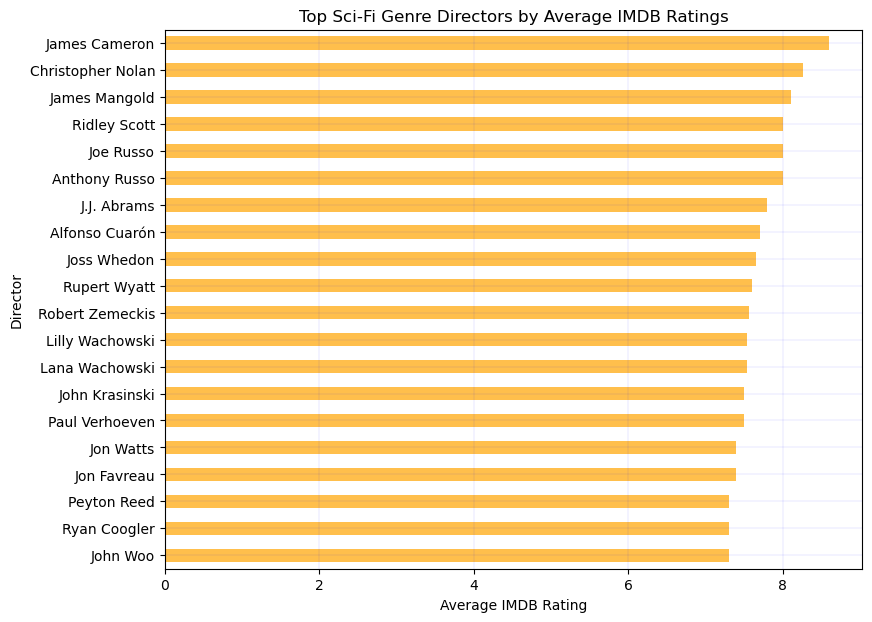

In [19]:
# Plotting the chosen Genre directors by avg ratings
plot_data = genre_director_rating.set_index('Director').head(20).sort_values(['imdbRating'])
plot_data.plot(kind="barh", y= "imdbRating",figsize=(9,7), color = "orange", alpha = 0.7, title = f'Top {choice} Genre Directors by Average IMDB Ratings', legend = False)
plt.grid(color='blue', linestyle='-', linewidth=.07)
plt.xlabel('Average IMDB Rating')
plt.plot

In [20]:
genre_director_rating = genre_director_rating.loc[(genre_director_rating['Genre'] == choice)].sort_values(['GrossRevenue'], ascending = False)
genre_director_rating

,Genre,Director,imdbRating,GrossRevenue
883,Sci-Fi,Colin Trevorrow,6.900000,1.513529e+09
904,Sci-Fi,Joss Whedon,7.650000,1.462481e+09
1105,Sci-Fi,Ryan Coogler,7.300000,1.347000e+09
1090,Sci-Fi,J.A. Bayona,6.100000,1.309000e+09
984,Sci-Fi,Joe Russo,8.000000,1.305357e+09
983,Sci-Fi,Anthony Russo,8.000000,1.305357e+09
1944,Sci-Fi,Shane Black,7.100000,1.215440e+09
1160,Sci-Fi,Ryan Fleck,6.800000,1.128000e+09
1159,Sci-Fi,Anna Boden,6.800000,1.128000e+09
1027,Sci-Fi,Jon Watts,7.400000,8.802000e+08


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

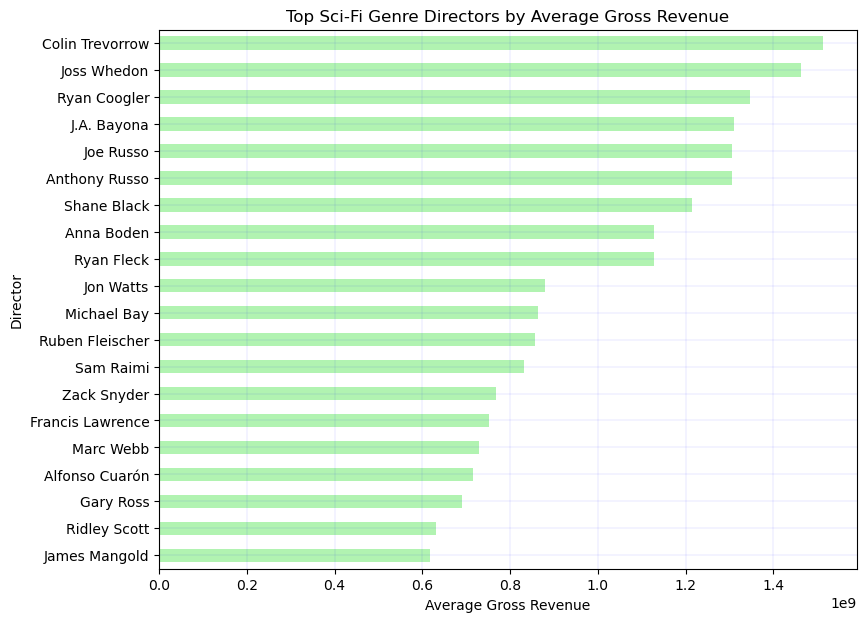

In [21]:
# Plotting the chosen Genre directors by avg Gross Revenue
plot2_data = genre_director_rating.set_index('Director').head(20).sort_values(['GrossRevenue'])
plot2_data.plot(kind="barh", y= "GrossRevenue", figsize=(9,7), color = "lightgreen", alpha = 0.7, title = f'Top {choice} Genre Directors by Average Gross Revenue', legend = False)
plt.grid(color='blue', linestyle='-', linewidth=.07)
plt.xlabel('Average Gross Revenue')
plt.plot